In [1]:
import pandas as pd
import numpy as np
import pyro 

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

In [2]:
def normalize_sample(sample: torch.Tensor, k: int = 1000) -> torch.Tensor:
    ''' 
    `sample` is supposed to be a sample of values, returns probabilites across k bins.
    '''

    hist = torch.histc(sample, bins=k)
    return hist / hist.sum()


$entropy(p) = - \sum p_i log p_i$

In [3]:

def weight(posterior: torch.Tensor, base=2.) -> float:
    '''
    Calculates the weight of the posterior distribution.
    The weight is defined as 1 - H(posterior) / H(uniform)
    where H is the entropy of the distribution.
        param: posterior: torch.Tensor - tensor of probabilities (not samples). 
    '''
    
    if not isinstance(base, torch.Tensor):  # Check if base is not a tensor
        base = torch.tensor(base) 

    initial_length = posterior.shape[-1]
    posterior = posterior[~torch.isnan(posterior)]
    removed_length = initial_length - posterior.shape[-1]

    if initial_length != posterior.shape[-1]:#raise warning
        warnings.warn(f"Removed {removed_length} nan values from posterior")

    if posterior.numel() == 0:
        return float('nan')

    grid_length = posterior.shape[-1]
    x = torch.linspace(0, 1, grid_length)

    uniform = dist.Beta(1, 1).log_prob(x).exp()
    uniform = uniform/uniform.sum()

    #uniform = normalize_sample(uniform, k = uniform.shape[-1])

    assert torch.allclose(uniform.sum(), torch.tensor(1.)), f"Sum of uniform distribution is {uniform.sum()}"
    assert torch.allclose(posterior.sum(), torch.tensor(1.)), f"Sum of posterior distribution is {posterior.sum()}"

    entropy_uniform = -torch.sum(uniform * torch.log(uniform) /torch.log(base))

    entropy_posterior = -torch.sum(posterior * torch.log(posterior) / torch.log(torch.tensor(base)))

    return 1 - entropy_posterior.item() / entropy_uniform.item()


In [4]:

def weight_numpy(posterior: List[torch.Tensor], base=2) -> float:
    posterior = np.array(posterior)

    posterior = posterior[~np.isnan(posterior)]
    
    if len(posterior) == 0:
        return np.nan  
    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1)
    entropy_uniform = entropy(uniform, base=base)
    entropy_posterior = entropy(posterior, base=base)

    return 1 - entropy_posterior / entropy_uniform


\begin{equation*}
EXPVAL[E, PRIOR] = \sum_1^k P(S_i|PRIOR) \times VAL[E_i, PRIOR].
\end{equation*}

\begin{equation*}
E_{Vchange}[E, PRIOR] = \sum_1^k \left( P(E_i|PRIOR) \times \left[ VAL(POSTERIOR_{E_i}) - VAL(PRIOR) \right]\right) .
\end{equation*}

In [5]:


def expected_weight(probs_of_evidence: torch.Tensor, outcome_prior: torch.Tensor,
                    posteriors: List[torch.Tensor],  base=2) -> torch.Tensor:
    
 
    weight_prior = weight(outcome_prior, base=base) 

    posterior_weights = torch.tensor([weight(posterior, base=base) for posterior in posteriors])

    print(posterior_weights)
    weight_changes = posterior_weights - weight_prior

    weighted_weight_changes = weight_changes * probs_of_evidence 
    
    assert probs_of_evidence.shape == weighted_weight_changes.shape, 'shape mismatch'

    expected_weight = weighted_weight_changes.sum()

    return {"expected_weight": expected_weight, "weight_prior": weight_prior, 
            "posterior_weights": posterior_weights, 
            "weight_changes": weight_changes, 
            "weighted_weight_changes": weighted_weight_changes}    

In [6]:
probs_of_evidence = torch.tensor([0.1, 0.5, 0.4])
outcome_prior = torch.tensor([0.25, 0.25, 0.25, 0.25])
posteriors = [torch.tensor([0.6, 0.2, 0.1, 0.1]),
                torch.tensor([0.3, 0.4, 0.1, 0.2]), 
                torch.tensor([0.25, 0.35, 0.2, 0.2]),
            ]

result = expected_weight(probs_of_evidence, outcome_prior, posteriors)
print(result)


tensor([0.2145, 0.0768, 0.0206])
{'expected_weight': tensor(0.0681), 'weight_prior': 0.0, 'posterior_weights': tensor([0.2145, 0.0768, 0.0206]), 'weight_changes': tensor([0.2145, 0.0768, 0.0206]), 'weighted_weight_changes': tensor([0.0215, 0.0384, 0.0082])}


/tmp/ipykernel_28922/785513576.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  entropy_posterior = -torch.sum(posterior * torch.log(posterior) / torch.log(torch.tensor(base)))


In [7]:
P_Father = 0.5
P_Not_Father = 0.5

P_C_given_Father = 0.95  # confession given Father
P_C_given_Not_Father = 0.01  # confession given Not Father

P_A_given_Father = 0.3  # angle given Father
P_A_given_Not_Father = 0.7  # angle given Not Father

P_F_given_Father = 0.9  # dingerprints given Father
P_F_given_Not_Father = 0.1  # fingerprints given Not Father


P_C_A_F_given_Father = P_C_given_Father * P_A_given_Father * P_F_given_Father
P_C_A_F_given_Not_Father = P_C_given_Not_Father * P_A_given_Not_Father * P_F_given_Not_Father


P_C_A_F = (P_C_A_F_given_Father * P_Father) + (P_C_A_F_given_Not_Father * P_Not_Father)


P_Father_given_C_A_F = (P_C_A_F_given_Father * P_Father) / P_C_A_F


P_C_A_given_Father = P_C_given_Father * P_A_given_Father
P_C_A_given_Not_Father = P_C_given_Not_Father * P_A_given_Not_Father


P_C_A = (P_C_A_given_Father * P_Father) + (P_C_A_given_Not_Father * P_Not_Father)


P_Father_given_C_A = (P_C_A_given_Father * P_Father) / P_C_A

print(f" P(Father|C,A,F) = {P_Father_given_C_A_F};   P(Father|C,A) = {P_Father_given_C_A}")

 P(Father|C,A,F) = 0.9972783825816486;   P(Father|C,A) = 0.976027397260274


A model of 6 possible scenarios



| Scenario | Fingerprints Evidence | Angle Evidence        |
|----------|-----------------------|-----------------------|
| 1        | Father                 | No angle evidence     |
| 2        | Son                    | No angle evidence     |
| 3        | No                     | No angle evidence     |
| 4        | Father                 | Angle evidence favors son |
| 5        | Son                    | Angle evidence favors son |
| 6        | No                     | Angle evidence favors son |


In [11]:
#set pyro seed
pyro.set_rng_seed(42)
def tinbox_core_no_son(
        pr_father: float = 0.8, 
        pr_confession_if_father = 0.9,
        pr_confession_if_not_father = .01,
        father_fingerprints_if_father = .2,
        father_fingerprints_if_not_father = .1,
        other_fingerprints_if_father = .01,
        other_fingerprints_if_not_father = .2,
        angle_if_father = .4,
        angle_if_not_father = .5, 
        num_particles = 3e4#should be wide uniform really
        ):
        with pyro.plate("inner_particles", size=num_particles):
                father = pyro.sample("father", dist.Bernoulli(pr_father))

                prob_confession = pyro.deterministic("prob_confession",
                        father * pr_confession_if_father + (1-father) * pr_confession_if_not_father)
                
                confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

                prob_father_fingerprints = pyro.deterministic("prob_father_fingerprints",
                        father * father_fingerprints_if_father + (1-father) * 
                        father_fingerprints_if_not_father)
                
                father_fingerprints = pyro.sample("father_fingerprints",
                                                   dist.Bernoulli(prob_father_fingerprints))
                
                prob_other_fingerprints = pyro.deterministic("prob_other_fingerprints",
                        father * other_fingerprints_if_father + (1-father) * 
                        other_fingerprints_if_not_father)
                
                other_fingerprints = pyro.sample("other_fingerprints",
                                                        dist.Bernoulli(prob_other_fingerprints))
                
                angle_prob = pyro.deterministic("angle_prob",
                        father * angle_if_father + (1-father) * angle_if_not_father)
                
                angle = pyro.sample("angle", dist.Bernoulli(angle_prob))

        # a bit hacky, but we want to run it inside other models, so we 
        # avoid running real inference here, using this poor man's 
        # rejection sampling
       
                evidence_mask_father_fingerprint = (confession  *  angle *
                                        father_fingerprints * (1-other_fingerprints)).bool()

                evidence_mask_no_fingerprint = (confession * angle).bool()

                evidence_mask_not_fathers_fingerprint = (confession  * (
                1-father_fingerprints) * other_fingerprints * angle).bool()

        
                father_masked_fathers_fingerprint = pyro.deterministic("father_masked_fingerprint",
                torch.where(evidence_mask_father_fingerprint, father, torch.tensor(float("nan"))))

                father_masked_no_fingerpint = pyro.deterministic("father_masked_no_fingerprint",
                        torch.where(evidence_mask_no_fingerprint, father, torch.tensor(float("nan"))))
                
                father_masked_not_fathers_fingerprint = pyro.deterministic("father_masked_not_fathers_fingerprint",
                torch.where(evidence_mask_not_fathers_fingerprint, father, torch.tensor(float("nan"))))
        
        
        
        posterior_father_fathers_fingerprint = pyro.deterministic(
                "posterior_father_fathers_fingerprint", torch.nanmean(father_masked_fathers_fingerprint,
                                                                      axis=0))
        
        posterior_father_no_fingerprint = pyro.deterministic(
                "posterior_father_no_fingerprint", torch.nanmean(father_masked_no_fingerpint, axis=0))
        
        
        posterior_father_not_fathers_fingerprint = pyro.deterministic(
                "posterior_father_not_fathers_fingerprint",
                        torch.nanmean(father_masked_not_fathers_fingerprint, axis=0))
        
        
        


/home/rafal/miniconda3/envs/chirho/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


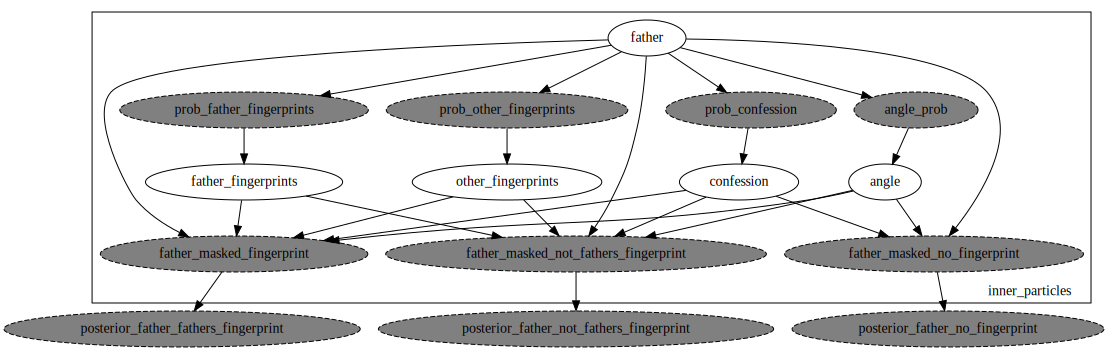

In [9]:
pyro.render_model(tinbox_core_no_son, render_deterministic = True)


In [25]:
with pyro.poutine.trace() as tr:
   pyro.set_rng_seed(42)
   tinbox_core_no_son(num_particles=1e6)

for key in tr.trace.nodes.keys():
        if key.startswith("posterior"):
                print(key, tr.trace.nodes[key]['value'])
                


posterior_father_fathers_fingerprint tensor(0.9985)
posterior_father_no_fingerprint tensor(0.9964)
posterior_father_not_fathers_fingerprint tensor(0.9318)


In [36]:

father_posterior_no_fingerprint = torch.tensor([
    1-tr.trace.nodes['posterior_father_no_fingerprint']['value'],
    tr.trace.nodes['posterior_father_no_fingerprint']['value'],
                    ])
father_posterior_fathers_fingerprint = torch.tensor([
    1-tr.trace.nodes['posterior_father_fathers_fingerprint']['value'],
    tr.trace.nodes['posterior_father_fathers_fingerprint']['value'],
                    ])
father_posterior_others_fingerprint = torch.tensor([
    1-tr.trace.nodes['posterior_father_not_fathers_fingerprint']['value'],
    tr.trace.nodes['posterior_father_not_fathers_fingerprint']['value'],
                    ])

print(father_posterior_no_fingerprint)
print(father_posterior_fathers_fingerprint)
print(father_posterior_others_fingerprint)

pr_father: float = 0.8 
pr_confession_if_father = 0.9
pr_confession_if_not_father = .01
father_fingerprints_if_father = .2
father_fingerprints_if_not_father = .1
other_fingerprints_if_father = .01
other_fingerprints_if_not_father = .2

pr_father_now = tr.trace.nodes['posterior_father_no_fingerprint']['value']

father_prior_now = torch.tensor([1-pr_father_now, pr_father_now])

print("prior now", father_prior_now)

pr_fathers_fingerprint_now = pr_father_now * father_fingerprints_if_father + (
    1-pr_father_now) * father_fingerprints_if_not_father

print("fathers", pr_fathers_fingerprint_now)

pr_other_fingerprints_now = pr_father_now * other_fingerprints_if_father + (
    1-pr_father_now) * other_fingerprints_if_not_father

print("others", pr_other_fingerprints_now)

pr_no_fingerprints_now = 1 - pr_fathers_fingerprint_now - pr_other_fingerprints_now

print("none", pr_no_fingerprints_now)

probs_of_evidence_no_son = torch.tensor([pr_fathers_fingerprint_now, 
                                         pr_other_fingerprints_now, pr_no_fingerprints_now,])
print(probs_of_evidence_no_son)

tensor([0.0036, 0.9964])
tensor([0.0015, 0.9985])
tensor([0.0682, 0.9318])
prior now tensor([0.0036, 0.9964])
fathers tensor(0.1996)
others tensor(0.0107)
none tensor(0.7897)
tensor([0.1996, 0.0107, 0.7897])


In [ ]:
expected_weights_no_son = expected_weight(
    probs_of_evidence_no_son, father_prior_now, 
    [father_posterior_fathers_fingerprint, father_posterior_others_fingerprint, 
     father_posterior_no_fingerprint]
     )

print(expected_weights_no_son)

In [5]:

def tinbox_core(
    pr_father,
    pr_confession_if_father,
    pr_confession_if_son,
    pr_angle_if_son,
    pr_angle_if_father,
    pr_father_fingerprints_if_father,
    pr_father_fingerprints_if_son,
    pr_son_fingerprints_if_father,
    pr_son_fingerprints_if_son,
    scenario="no_fingerprints",
    angle_value=1  
):
    with pyro.plate("tinbox_core_estimation", size=1e4):
        father = pyro.sample("father", dist.Bernoulli(pr_father))
        son = pyro.deterministic("son", 1 - father, event_dim=0) 

        prob_confession = torch.where(father == 1, pr_confession_if_father, pr_confession_if_son)
        confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

        prob_angle = torch.where(father == 1, pr_angle_if_father, pr_angle_if_son)
        angle = pyro.sample("angle", dist.Bernoulli(prob_angle))

        prob_father_fingerprints = torch.where(father == 1, pr_father_fingerprints_if_father, pr_father_fingerprints_if_son)
        father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(prob_father_fingerprints))

        prob_son_fingerprints = torch.where(father == 1, pr_son_fingerprints_if_father, pr_son_fingerprints_if_son)
        son_fingerprints = pyro.sample("son_fingerprints", dist.Bernoulli(prob_son_fingerprints))


# the possible scenarios
    if scenario == "no_fingerprints":

        evidence_mask = (confession == 1) & (angle == 1)
    elif scenario == "son_fingerprints":

        evidence_mask = (confession == 1) & (angle == 1) & (son_fingerprints == 1) & (father_fingerprints == 0)
    elif scenario == "father_fingerprints":

        evidence_mask = (confession == 1) & (angle == 1) & (son_fingerprints == 0) & (father_fingerprints == 1)
    elif scenario == "no_fingerprints_no_angle":
  
        evidence_mask = (confession == 1) & (angle == 0)
    elif scenario == "son_fingerprints_no_angle":

        evidence_mask = (confession == 1) & (angle == 0) & (son_fingerprints == 1) & (father_fingerprints == 0)
    elif scenario == "father_fingerprints_no_angle":

        evidence_mask = (confession == 1) & (angle == 0) & (son_fingerprints == 0) & (father_fingerprints == 1)
        


    # filtered_son = torch.where(evidence_mask, son, torch.tensor(float("nan")))
    # posterior_son = torch.nanmean(filtered_son, axis=0)
    
    filtered_father = torch.where(evidence_mask, father, torch.tensor(float("nan")))
    posterior_father = torch.nanmean(filtered_father, axis=0)

    return posterior_father


def tinbox_model(scenario):

    pr_father = pyro.sample("pr_father", dist.Uniform(0, 1))


    pr_confession_if_father = pyro.sample("pr_confession_if_father", dist.Beta(5, 6))
    pr_confession_if_son = pyro.sample("pr_confession_if_son", dist.Beta(6, 5))


    pr_angle_if_son = pyro.sample("pr_angle_if_son", dist.Beta(8, 5))
    pr_angle_if_father = pyro.sample("pr_angle_if_father", dist.Beta(5, 8))

    pr_father_fingerprints_if_father = pyro.sample(
        "pr_father_fingerprints_if_father", dist.Beta(999, 3)
    )
    pr_father_fingerprints_if_son = pyro.sample(
        "pr_father_fingerprints_if_son", dist.Beta(5, 96)
    )
    pr_son_fingerprints_if_father = pyro.sample(
        "pr_son_fingerprints_if_father", dist.Beta(5, 96)
    )
    pr_son_fingerprints_if_son = pyro.sample(
        "pr_son_fingerprints_if_son", dist.Beta(999, 3)
    )

    posterior_father = tinbox_core(
        pr_father,
        pr_confession_if_father,
        pr_confession_if_son,
        pr_angle_if_son,
        pr_angle_if_father,
        pr_father_fingerprints_if_father,
        pr_father_fingerprints_if_son,
        pr_son_fingerprints_if_father,
        pr_son_fingerprints_if_son,
        scenario=scenario
    )


   # pyro.deterministic("posterior_son", posterior_son, event_dim=0)
    pyro.deterministic("posterior_father", posterior_father, event_dim=0)
    


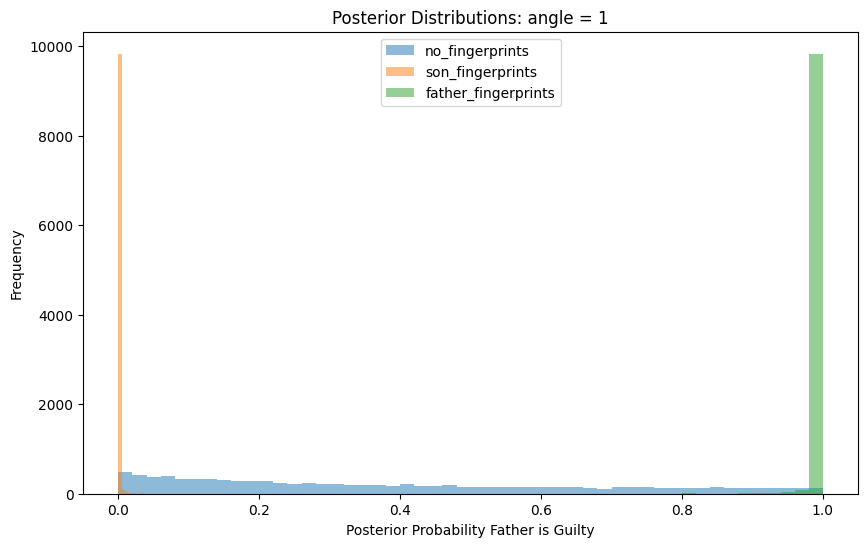

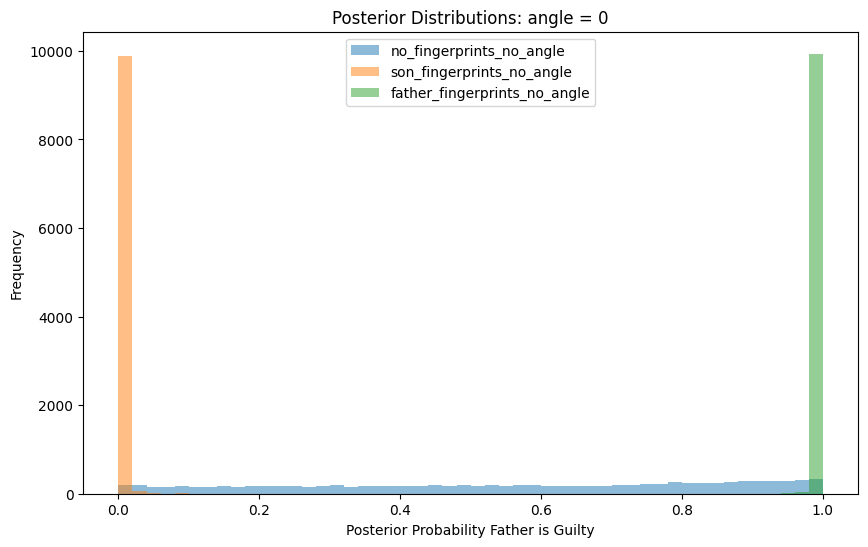

In [6]:

# Running the model for different scenarios    

def run_scenarios(angle):
    
    if angle == 1:
    
        scenarios = ["no_fingerprints", "son_fingerprints", "father_fingerprints"]
        
    elif angle == 0:
        scenarios = ["no_fingerprints_no_angle", "son_fingerprints_no_angle", "father_fingerprints_no_angle"]
        
    results = {}
    
    for scenario in scenarios:
        with pyro.plate("samples", size=10000):
            with pyro.poutine.trace() as tr:
                tinbox_model(scenario)
        results[scenario] = tr.trace.nodes["posterior_father"]["value"].detach().numpy()
    
    return results

scenario_posteriors_angle = run_scenarios(angle=1)
scenario_posteriors_no_angle = run_scenarios(angle=0)


# plot for angle=1

plt.figure(figsize=(10, 6))

for scenario, posterior in scenario_posteriors_angle.items():
    plt.hist(posterior, bins=50, alpha=0.5, label=scenario)

plt.title("Posterior Distributions: angle = 1")
plt.xlabel("Posterior Probability Father is Guilty")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# no angle plot


plt.figure(figsize=(10, 6))

for scenario, posterior in scenario_posteriors_no_angle.items():
    plt.hist(posterior, bins=50, alpha=0.5, label=scenario)

plt.title("Posterior Distributions: angle = 0")
plt.xlabel("Posterior Probability Father is Guilty")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Weights

In [7]:
# function for calculating weights of all the scenarios
def calculate_weights(scenario: Dict[str, List[float]]) -> Dict[str, float]:
    weights = {}
    for key, posterior in scenario.items():
        weight_value = weight(posterior) 
        weights[key] = weight_value
    return weights

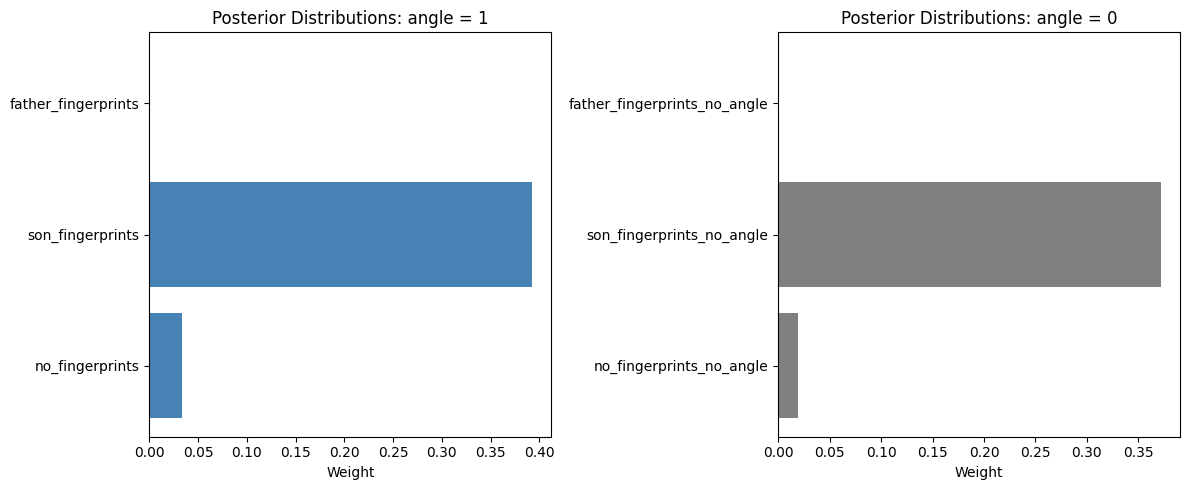

In [8]:
weights_angle = calculate_weights(scenario_posteriors_angle)
weights_no_angle = calculate_weights(scenario_posteriors_no_angle)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].barh(list(weights_angle.keys()), list(weights_angle.values()), color='steelblue')
axs[0].set_title('Posterior Distributions: angle = 1')
axs[0].set_xlabel('Weight')


axs[1].barh(list(weights_no_angle.keys()), list(weights_no_angle.values()), color='gray')
axs[1].set_title('Posterior Distributions: angle = 0')
axs[1].set_xlabel('Weight')

plt.tight_layout()
plt.show()

Condition and intervention approach graveyard

In [9]:
# conditioned_model = pyro.condition(
#     tinbox_model, 
#     data={
#         "father": torch.tensor(0.0),  # Son did it
#         "father_fingerprints": torch.tensor(0.0),  # Son's fingerprints
#         "angle": torch.tensor(0.9)  
#     }
# )


# with pyro.plate("samples", 10000):
#     with pyro.poutine.trace() as tr_uncond:
#         posterior_uncond = tinbox_model()

# nodes_uncond = tr_uncond.trace.nodes


# for key in nodes_uncond.keys():
#     if key.startswith("posterior"):
#         plot_site(nodes_uncond, key)
        

# for key in nodes_cond.keys():
#     if key.startswith("posterior"):
#         plt.figure()
#         plt.hist(nodes_uncond[key]["value"].detach().numpy(), bins=50, alpha=0.5, label="Unconditioned")
#         # plt.hist(nodes_cond[key]["value"].detach().numpy(), bins=50, alpha=0.5, label="Conditioned")
#         plt.title(f"Comparison for {key}")
#         plt.legend()
#         plt.show()




# intervention_model = pyro.do(
#     tinbox_model, 
#     data={
#         "father_fingerprints": torch.tensor(1.0), 
#     }
# )


# posterior = intervention_model()
# weight_value = weight(posterior)
# weight_value

## Ways to visualize DAGs

Graphviz


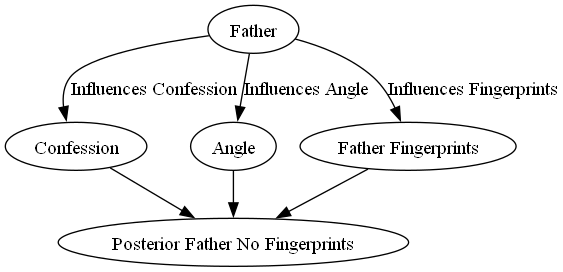

In [12]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(comment="Murder Case DAG")

dot.node('F', 'Father')
dot.node('C', 'Confession')
dot.node('A', 'Angle')
dot.node('FF', 'Father Fingerprints')
dot.node('P', 'Posterior Father No Fingerprints')

dot.edge('F', 'C', label="Influences Confession")
dot.edge('F', 'A', label="Influences Angle")
dot.edge('F', 'FF', label="Influences Fingerprints")
dot.edge('C', 'P')
dot.edge('A', 'P')
dot.edge('FF', 'P')


png_path = dot.render('murder_case_dag', format='png') # saving the PNG

display(Image(png_path))


Dagitty


In [ ]:
# library(dagitty)
# library(ggplot2)

# dag <- dagitty('
#     dag {
#         Father [label="Father"]
#         Confession [label="Confession"]
#         Angle [label="Angle"]
#         FatherFingerprints [label="Father Fingerprints"]
#         PosteriorFatherNoFingerprints [label="Posterior Father No Fingerprints"]
#         Father -> Confession
#         Father -> Angle
#         Father -> FatherFingerprints
#         Confession -> PosteriorFatherNoFingerprints
#         Angle -> PosteriorFatherNoFingerprints
#         FatherFingerprints -> PosteriorFatherNoFingerprints
#     }
# ')

# plot(dag)

# p <- plot(dag)
# ggsave("dag_plot_no_abbreviations.png", plot = p)


![](tinbox_dagitty_plot.png){ fig-align="center" width="60%"}